In [93]:
from __future__ import print_function

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import torch



import os
import sys
import glob
import h5py
import numpy as np
import math


import torch
from torch import nn
from torch.autograd import Variable
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset , DataLoader
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
from tqdm import tqdm
import tensorboard
import tensorboardX
from torch.utils.tensorboard import SummaryWriter


from log import Logger
from data import gDataset, trainDataset, testDataset
from util import r2, mse, rmse, mae, pp_mse, pp_rmse, pp_mae
from model import autoencoder_6
from sklearn.decomposition import PCA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def showres(path):
    img_data_tensor=torch.load(path)
    img_data= img_data_tensor[4].numpy()
    img_data.resize(56,56)
    plt.imshow(img_data)
    return img_data

In [94]:
if not os.path.exists('./gal_img917'):
    os.mkdir('./gal_img917')
    
def to_img(x):   # image size 56 * 56 
    x = x.view(x.size(0), 1, 56, 56)
    return x


test_dataset = testDataset()
test_dataloader= DataLoader(dataset=test_dataset, batch_size=3000,shuffle=True)


model = autoencoder_6().cuda()   ###### AE model 
model.load_state_dict(torch.load('gal_img917/exp2_sim_autoencoder.pth'))    
model.eval()


for data in test_dataloader:
    test_img = data
    test_img = test_img.type(torch.float32)
    test_img = test_img.view(test_img.size(0), 1,56,56)
    test_img = test_img.cuda()
    test_output = model.encoder(test_img)   #latent 
    
a=test_output.data.cpu().numpy()

print("finished")

finished


In [109]:
orig0=((test_img[0].reshape([56,56])).data).cpu().numpy()

#plt.imshow(orig0)

In [96]:
dt_test = a.reshape([3000,-1])
pca = PCA()
pca.fit(dt_test)
evr = pca.explained_variance_ratio_   # 
evr.shape


(2304,)

In [97]:
features = pca.components_

In [98]:
np.where(evr>0.001)  # >0.1% ,  8 important factors picked out by pca 

(array([0, 1, 2, 3, 4, 5, 6, 7]),)

In [99]:
M = features

In [100]:
important_features = np.einsum('ij,nj->ni',M,dt_test)
mean_feature = np.mean(important_features,axis=0)
M_inv = np.linalg.inv(M)
feature_0 = important_features[0]

In [101]:
feature_new = np.zeros(feature_0.shape)
feature_new[0:8] = feature_0[0:8]
feature_new[8:] = mean_feature[8:]
latent_new = np.matmul(M_inv, feature_new)
latent_compare = dt_test[0]
latent_new = latent_new.reshape([1,256,3,3])
latent_compare = latent_compare.reshape([1,256,3,3])


In [102]:
latent_compare_tensor = torch.from_numpy(latent_compare).float().to(device)
latent_new_tensor = torch.from_numpy(latent_compare).float().to(device)

In [108]:
img_compare = model.decoder(latent_compare_tensor)
img_new = model.decoder(latent_new_tensor)

img_new_n=img_new.reshape([56,56])

img_new_np=(img_new_n.data).cpu().numpy()
#plt.imshow(img_new_np)

In [104]:
img0 = torch.Tensor.cpu(img_compare)

Text(0.5, 1.0, 'decoded with 8 important factors picked out by PCA')

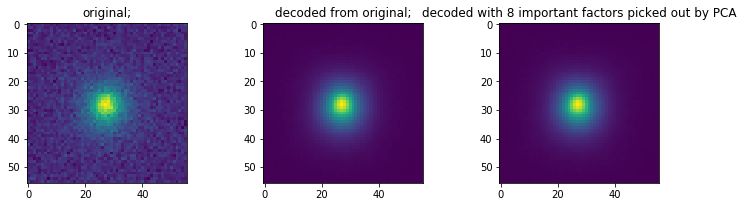

In [106]:
plt.figure(figsize=(12,10))
plt.subplot(331)
plt.imshow(orig0)
plt.title('original;')
plt.subplot(332)
plt.imshow(cc)
plt.title('decoded from original;')
plt.subplot(333)
plt.imshow(img_new_np)
plt.title('decoded with 8 important factors picked out by PCA')

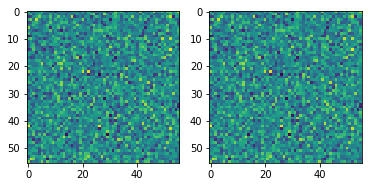

In [107]:
plt.subplot(1, 2, 1)
plt.imshow(orig0 - cc)
#plt.title('difference btw original image and decoded image ')

plt.subplot(1, 2, 2)
plt.imshow(orig0-img_new_np)
#plt.title('difference btw original image and decoded image with 8 important factors picked out by PC')
